In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [18]:

# Load the data
file_path = "data/imu_data_20250126_135755.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to ensure it loaded correctly
print("Data preview:")
print(data.head())


Data preview:
      Timestamp  Accel_X  Accel_Y  Accel_Z  Gyro_X  Gyro_Y  Gyro_Z
0  1.737929e+09    -0.48     6.87     9.34   -0.31    3.35    8.06
1  1.737929e+09    -0.81     4.57     7.47   -1.59    4.79    8.71
2  1.737929e+09    -1.89     4.06     8.90   -0.52    6.76    9.15
3  1.737929e+09     3.67     4.67     7.54    0.94    1.76    9.11
4  1.737929e+09     0.27     3.70    10.06    0.13    5.82   12.59


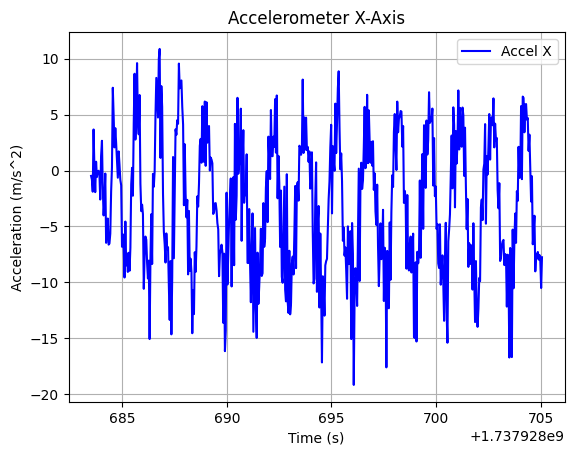

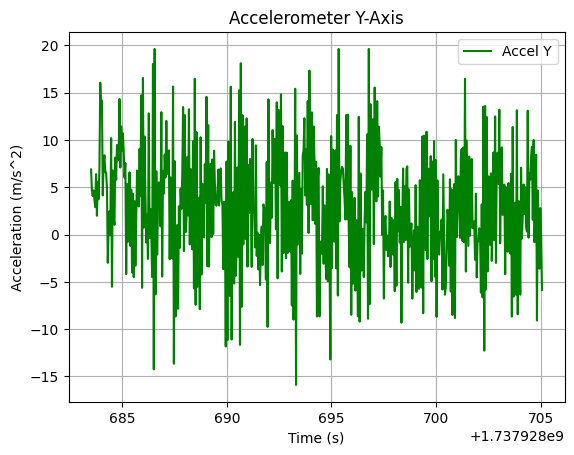

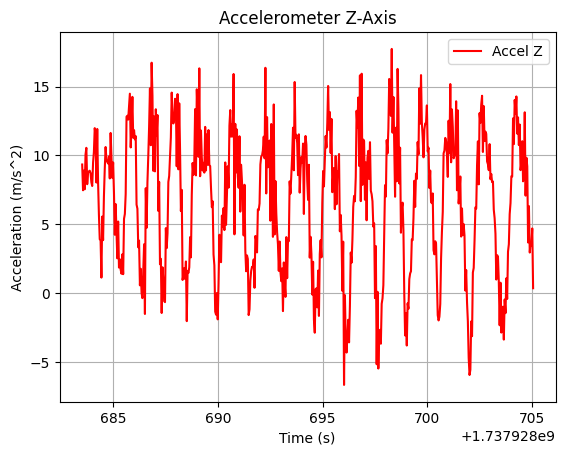

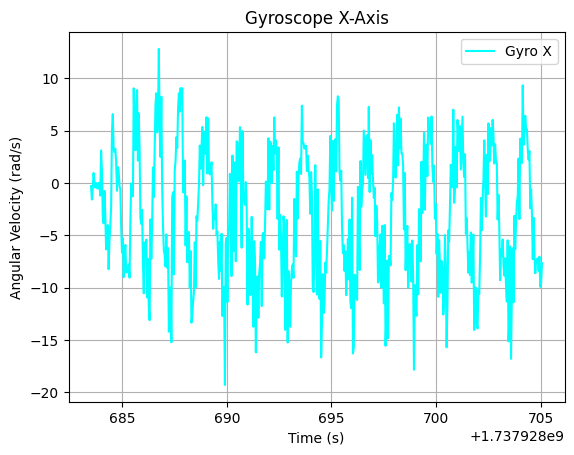

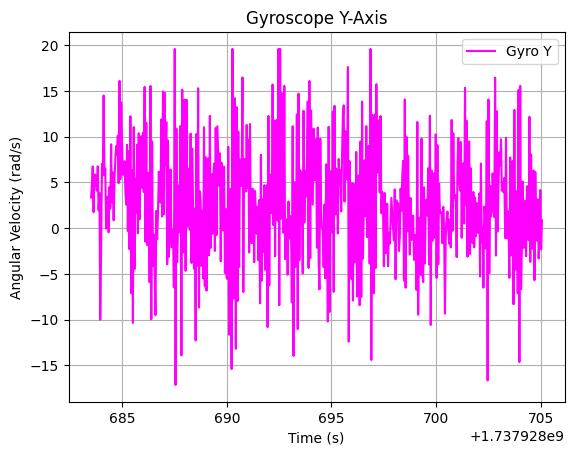

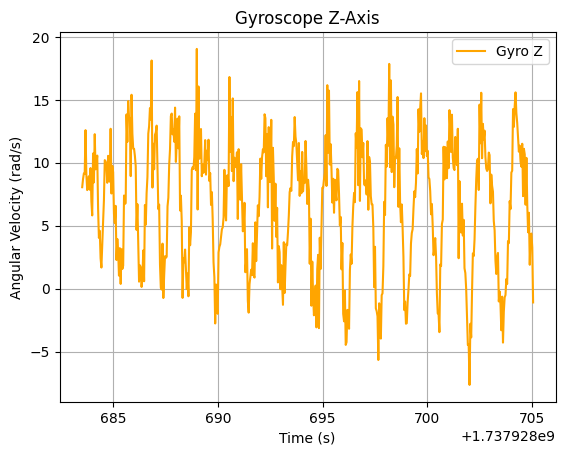

In [19]:
# Flag to show or hide plots
show_plots = True

# Extract the columns
timestamps = data['Timestamp']
accel_x = data['Accel_X']
accel_y = data['Accel_Y']
accel_z = data['Accel_Z']
gyro_x = data['Gyro_X']
gyro_y = data['Gyro_Y']
gyro_z = data['Gyro_Z']

# Create separate plots for each axis
if show_plots:
    # Accelerometer X
    plt.figure()
    plt.plot(timestamps, accel_x, label="Accel X", color='blue')
    plt.title("Accelerometer X-Axis")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Accelerometer Y
    plt.figure()
    plt.plot(timestamps, accel_y, label="Accel Y", color='green')
    plt.title("Accelerometer Y-Axis")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Accelerometer Z
    plt.figure()
    plt.plot(timestamps, accel_z, label="Accel Z", color='red')
    plt.title("Accelerometer Z-Axis")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Gyroscope X
    plt.figure()
    plt.plot(timestamps, gyro_x, label="Gyro X", color='cyan')
    plt.title("Gyroscope X-Axis")
    plt.xlabel("Time (s)")
    plt.ylabel("Angular Velocity (rad/s)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Gyroscope Y
    plt.figure()
    plt.plot(timestamps, gyro_y, label="Gyro Y", color='magenta')
    plt.title("Gyroscope Y-Axis")
    plt.xlabel("Time (s)")
    plt.ylabel("Angular Velocity (rad/s)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Gyroscope Z
    plt.figure()
    plt.plot(timestamps, gyro_z, label="Gyro Z", color='orange')
    plt.title("Gyroscope Z-Axis")
    plt.xlabel("Time (s)")
    plt.ylabel("Angular Velocity (rad/s)")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Plots are hidden. Set `show_plots = True` to display them.")

    


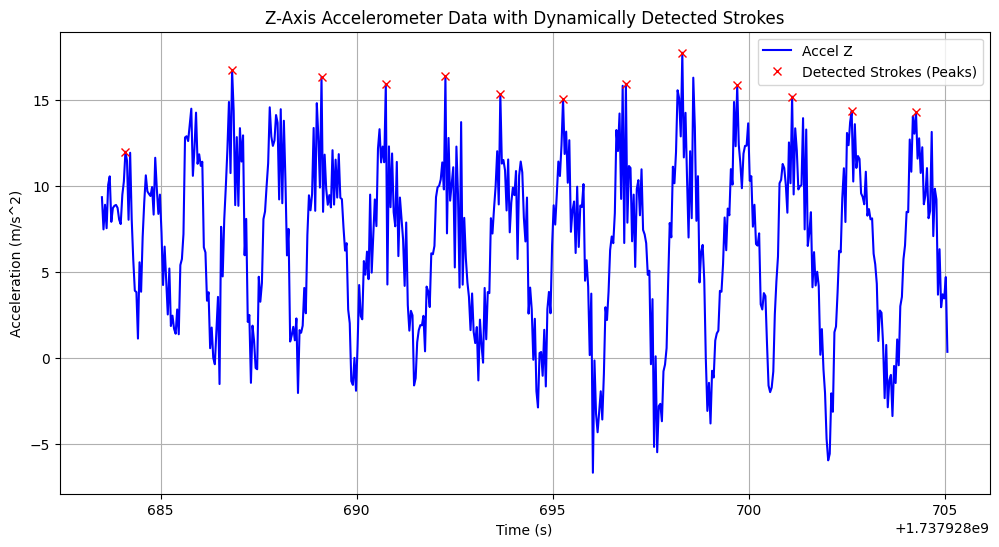

Mean: 6.77, Std Dev: 4.95, Max: 17.73
Dynamic Height Threshold: 7.76
Dynamic Distance Threshold: 30 samples
Total Detected Peaks: 13


In [29]:
from scipy.signal import find_peaks
import numpy as np

# Extract Z-axis data
timestamps = data['Timestamp']
accel_z = data['Accel_Z']

# Calculate dynamic thresholds
mean_value = np.mean(accel_z)
std_dev = np.std(accel_z)
max_value = np.max(accel_z)

# Dynamically set the 'height' threshold based on mean and standard deviation
height_threshold = mean_value + 0.2 * std_dev  # Adjust multiplier (1.5) as needed

# Dynamically set the 'distance' between peaks (based on sampling rate or data characteristics)
sampling_rate = 60  # Assuming data is collected at 60Hz
distance_threshold = int(sampling_rate / 2)  # Minimum distance: ~0.5 seconds

# Detect peaks
peaks, properties = find_peaks(
    accel_z,
    height=height_threshold,  # Minimum height
    distance=distance_threshold,  # Minimum distance between peaks
    prominence=0.5 * std_dev  # Optional: Require significant prominence
)

# Plot the Z-axis data with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(timestamps, accel_z, label='Accel Z', color='blue')
plt.plot(timestamps[peaks], accel_z[peaks], 'rx', label='Detected Strokes (Peaks)')
plt.title('Z-Axis Accelerometer Data with Dynamically Detected Strokes')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

# Print the dynamic parameters for debugging
print(f"Mean: {mean_value:.2f}, Std Dev: {std_dev:.2f}, Max: {max_value:.2f}")
print(f"Dynamic Height Threshold: {height_threshold:.2f}")
print(f"Dynamic Distance Threshold: {distance_threshold} samples")
print(f"Total Detected Peaks: {len(peaks)}")



In [32]:
# This block calculates the ground truth for average strokes per second and strokes per minute

import numpy as np
from scipy.signal import find_peaks

# Extract Z-axis data and timestamps
timestamps = data['Timestamp']
accel_z = data['Accel_Z']

# Dynamically calculate thresholds for peak detection
mean_value = np.mean(accel_z)
std_dev = np.std(accel_z)
max_value = np.max(accel_z)

# Find peaks dynamically
height_threshold = mean_value + 1.3 * std_dev  # Adjusted multiplier for leniency
distance_threshold = 20  # Adjust distance as needed
peaks, _ = find_peaks(accel_z, height=height_threshold, distance=distance_threshold)

# Total number of strokes (peaks)
total_strokes = len(peaks)

# Total time in seconds
total_time_seconds = timestamps.iloc[-1] - timestamps.iloc[0]  # Difference between first and last timestamp

# Total time in minutes
total_time_minutes = total_time_seconds / 60.0

# Calculate average stroke rates
average_stroke_rate_per_second = total_strokes / total_time_seconds
average_stroke_rate_per_minute = total_strokes / total_time_minutes

# Print results
print(f"Total Strokes (Peaks): {total_strokes}")
print(f"Total Time: {total_time_seconds:.2f} seconds ({total_time_minutes:.2f} minutes)")
print(f"Average Stroke Rate: {average_stroke_rate_per_second:.2f} strokes/second")
print(f"Average Stroke Rate: {average_stroke_rate_per_minute:.2f} strokes/minute")


Total Strokes (Peaks): 14
Total Time: 21.56 seconds (0.36 minutes)
Average Stroke Rate: 0.65 strokes/second
Average Stroke Rate: 38.96 strokes/minute


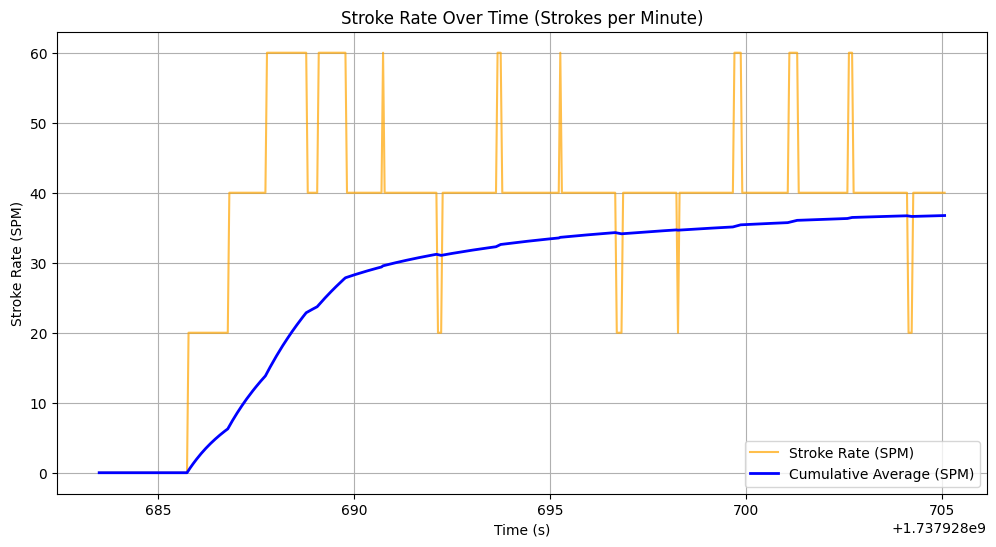

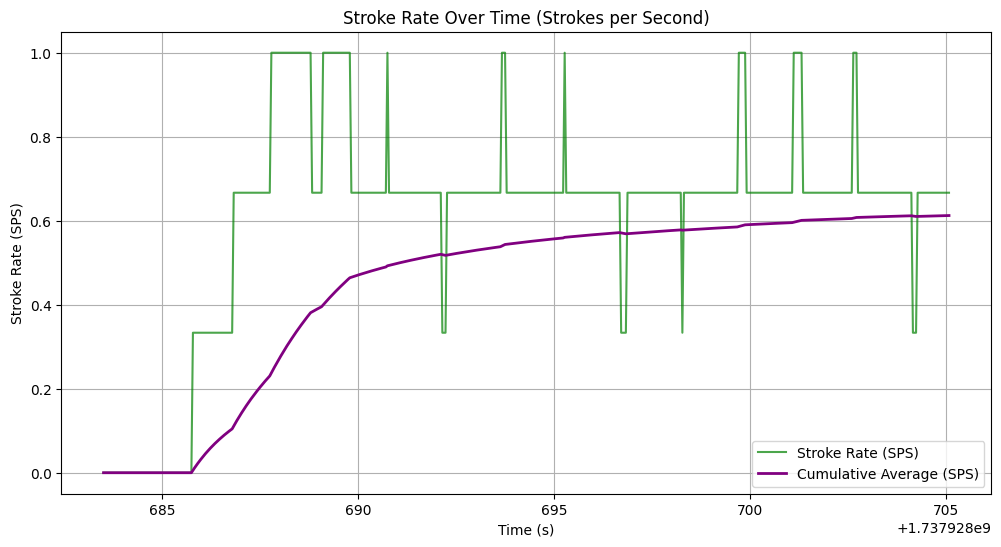

Final Cumulative Average Stroke Rate: 36.74 strokes/minute
Final Cumulative Average Stroke Rate: 0.61 strokes/second
Ground Truth Stroke Rate: 38.96 strokes/minute
Ground Truth Stroke Rate: 0.65 strokes/second


In [40]:
# This Block calculates stroke rate.
# It uses a sliding time window of the last 3 seconds to count 
# how many strokes occurred in that time.

import pandas as pd
import matplotlib.pyplot as plt

# Calculate stroke rate (SPM: Strokes Per Minute) and SPS (Strokes Per Second)
stroke_rate_spm = []
stroke_rate_sps = []  # Strokes per second
cumulative_spm = []  # Cumulative average SPM
cumulative_sps = []  # Cumulative average SPS
window = 3  # Window size in seconds for stroke rate calculation

for i, t in enumerate(timestamps):
    # Count peaks in the last `window` seconds
    start_time = t - window
    valid_peaks = [p for p in peaks if timestamps[p] >= start_time and timestamps[p] <= t]
    
    # Stroke rate in strokes per minute
    rate_spm = len(valid_peaks) * (60 / window)  # Convert to strokes per minute
    stroke_rate_spm.append(rate_spm)
    
    # Stroke rate in strokes per second
    rate_sps = len(valid_peaks) / window  # Convert to strokes per second
    stroke_rate_sps.append(rate_sps)
    
    # Cumulative averages
    cumulative_spm.append(sum(stroke_rate_spm) / len(stroke_rate_spm))  # Average of SPM so far
    cumulative_sps.append(sum(stroke_rate_sps) / len(stroke_rate_sps))  # Average of SPS so far

# Plot the stroke rate (Strokes per Minute) with cumulative average
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_spm, label='Stroke Rate (SPM)', color='orange', alpha=0.7)
plt.plot(timestamps, cumulative_spm, label='Cumulative Average (SPM)', color='blue', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Minute)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPM)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the stroke rate (Strokes per Second) with cumulative average
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_sps, label='Stroke Rate (SPS)', color='green', alpha=0.7)
plt.plot(timestamps, cumulative_sps, label='Cumulative Average (SPS)', color='purple', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Second)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPS)')
plt.legend()
plt.grid(True)
plt.show()

# Final cumulative averages
final_spm_average = cumulative_spm[-1]  # Final cumulative average SPM
final_sps_average = cumulative_sps[-1]  # Final cumulative average SPS

# Ground truth values
total_strokes = len(peaks)  # Total number of peaks (strokes)
total_time_seconds = timestamps.iloc[-1] - timestamps.iloc[0]  # Total duration in seconds
total_time_minutes = total_time_seconds / 60.0  # Total duration in minutes
ground_truth_spm = total_strokes / total_time_minutes  # Ground truth strokes per minute
ground_truth_sps = total_strokes / total_time_seconds  # Ground truth strokes per second

# Print final cumulative averages and ground truth
print(f"Final Cumulative Average Stroke Rate: {final_spm_average:.2f} strokes/minute")
print(f"Final Cumulative Average Stroke Rate: {final_sps_average:.2f} strokes/second")
print(f"Ground Truth Stroke Rate: {ground_truth_spm:.2f} strokes/minute")
print(f"Ground Truth Stroke Rate: {ground_truth_sps:.2f} strokes/second")
